## クロージング処理

In [4]:
import cv2 
import numpy as  np
import matplotlib.pyplot as plt

def Canny_step3(img):

    # Gray scale
    def BGR2GRAY(img):
        b = img[:, :, 0].copy()
        g = img[:, :, 1].copy()
        r = img[:, :, 2].copy()

        # Gray scale
        out = 0.2126 * r + 0.7152 * g + 0.0722 * b
        out = out.astype(np.uint8)
        return out
    
    
    # Gaussian filter for grayscale
    def gaussian_filter(img, K_size=3, sigma=1.3):

        if len(img.shape) == 3:
            H, W, C = img.shape
            #gray = False
        else:
            img = np.expand_dims(img, axis=-1)
            H, W, C = img.shape
            #gray = True

        ## Zero padding
        pad = K_size // 2
        out = np.zeros([H + pad * 2, W + pad * 2, C], dtype=np.float)
        out[pad: pad + H, pad: pad + W] = img.copy().astype(np.float)

        ## prepare Kernel
        K = np.zeros((K_size, K_size), dtype=np.float)
        for x in range(-pad, -pad + K_size):
            for y in range(-pad, -pad + K_size):
                K[y + pad, x + pad] = np.exp( - (x ** 2 + y ** 2) / (2 * (sigma ** 2)))
        K /= (2 * np.pi * sigma * sigma)
        K /= K.sum()

        tmp = out.copy()

        # filtering
        for y in range(H):
            for x in range(W):
                for c in range(C):
                    out[pad + y, pad + x, c] = np.sum(K * tmp[y : y + K_size, x : x + K_size, c]) 
                        
        out = np.clip(out, 0, 255)
        out = out[pad : pad + H, pad : pad + W]
        out = out.astype(np.uint8)
        out = out[..., 0]

        #if gray:
         #   out = out[..., 0]

        return out
    
    # sobel filter
    def sobel_filter(img, K_size=3):
        if len(img.shape) == 3:
            H, W, C = img.shape
        else:
            #img = np.expand_dims(img, axis=-1)
            H, W = img.shape

        # Zero padding
        pad = K_size // 2
        out = np.zeros((H + pad * 2, W + pad * 2), dtype=np.float)
        out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float)
        tmp = out.copy()

        out_v = out.copy()
        out_h = out.copy()

        ## Sobel vertical
        Kv = [[1., 2., 1.],[0., 0., 0.], [-1., -2., -1.]]
        ## Sobel horizontal
        Kh = [[1., 0., -1.],[2., 0., -2.],[1., 0., -1.]]

        # filtering
        for y in range(H):
            for x in range(W):
                out_v[pad + y, pad + x] = np.sum(Kv * (tmp[y : y + K_size, x : x + K_size]))
                out_h[pad + y, pad + x] = np.sum(Kh * (tmp[y : y + K_size, x : x + K_size]))

        out_v = np.clip(out_v, 0, 255)
        out_h = np.clip(out_h, 0, 255)

        out_v = out_v[pad : pad + H, pad : pad + W].astype(np.uint8)
        out_h = out_h[pad : pad + H, pad : pad + W].astype(np.uint8)

        return out_v, out_h
    
    
    def get_edge_angle(fx, fy):
        # get edge strength
        edge = np.sqrt(np.power(fx.astype(np.float32), 2) + np.power(fy.astype(np.float32), 2))         
        edge = np.clip(edge, 0, 255)  # 新しく入れた処理
        fx = np.maximum(fx, 1e-5)

        # get edge angle
        angle = np.arctan(fy / fx)

        return edge, angle
    
    def angle_quantization(angle):
        angle = angle / np.pi * 180
        angle[angle < -22.5] = 180 + angle[angle < -22.5]
        _angle = np.zeros_like(angle, dtype=np.uint8)
        _angle[np.where(angle <= 22.5)] = 0
        _angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
        _angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
        _angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135
        
        return _angle
    
    
    def non_maximum_suppression(angle, edge):
        H, W =  angle.shape
        _edge = edge.copy()
        
        for y in range(H):
            for x in range(W):
                if angle[y, x] == 0:
                    dx1, dy1, dx2, dy2 = -1, 0, 1, 0
                elif angle[y,x] == 45:
                    dx1, dy1, dx2, dy2 = -1, 1, 1, -1
                elif angle[y, x] == 90:
                    dx1, dy1, dx2, dy2 = 0, -1, 0, 1
                elif angle[y, x] == 135:
                    dx1, dy1, dx2, dy2 = -1, -1, 1, 1
                    
                if x == 0:
                    dx1 = max(dx1, 0)
                    dx2 = max(dx2, 0)
                if x==W-1:
                    dx1 = min(dx1, 0)
                    dx2 = min(dx2, 0)
                    
                if y == 0:
                    dy1 = max(dy1, 0)
                    dy2 = max(dy2, 0)
                if y == H-1:
                    dy1 = min(dy1, 0)
                    dy2 = min(dy2, 0)
                    
                if max(max(edge[y,x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y,x]:
                    _edge[y, x] = 0
            
        return _edge
        
        
    def hys(edge, HT=50, LT=20):
        
        H, W = edge.shape
            
        # Hysterisis threshold
        edge[edge>=HT] = 255
        edge[edge<=LT] = 0
            
        # 端も計算できるようにpadding
        _edge = np.zeros([H+2, W+2], dtype=np.float32)
        _edge[1:1+H, 1:1+W] = edge
            
            # 8 - nearest neighbor
        nn = np.array([[1.,1.,1.], [1.,0.,1.], [1.,1.,1.]], dtype=np.float32)
          
        for y in range(1, H+2):
            for x in range(1, W+2):
                if _edge[y, x] < LT or _edge[y, x] > HT:
                    continue
                if np.max(_edge[y-1: y+2, x-1:x+2]*nn) >= HT:
                    _edge[y, x] = 255
                else:
                    _edge[y, x] = 0
                       
        edge = _edge[1:1+H, 1:1+W]
            
        return edge
        
                    
    
                    
                    
                    
    # grayscale
    gray = BGR2GRAY(img)

    # gaussian filtering
    gaussian = gaussian_filter(gray, K_size=5, sigma=1.4)

    # sobel filtering
    fy, fx = sobel_filter(gaussian, K_size=3)

    # get edge strength, angle
    edge, angle = get_edge_angle(fx, fy)

    # angle quantization
    angle = angle_quantization(angle)
    
    # non_maximum suppression
    edge = non_maximum_suppression(angle, edge)
    
    # hysterisis threshold
    out = hys(edge, 50, 20)

    return out






In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Gray scale
def BGR2GRAY(img):
	b = img[:, :, 0].copy()
	g = img[:, :, 1].copy()
	r = img[:, :, 2].copy()

	# Gray scale
	out = 0.2126 * r + 0.7152 * g + 0.0722 * b
	out = out.astype(np.uint8)

	return out

# Otsu Binalization
def otsu_binarization(img, th=128):
	H, W = img.shape
	out = img.copy()

	max_sigma = 0
	max_t = 0

	# determine threshold
	for _t in range(1, 255):
		v0 = out[np.where(out < _t)]
		m0 = np.mean(v0) if len(v0) > 0 else 0.
		w0 = len(v0) / (H * W)
		v1 = out[np.where(out >= _t)]
		m1 = np.mean(v1) if len(v1) > 0 else 0.
		w1 = len(v1) / (H * W)
		sigma = w0 * w1 * ((m0 - m1) ** 2)
		if sigma > max_sigma:
			max_sigma = sigma
			max_t = _t

	# Binarization
	print("threshold >>", max_t)
	th = max_t
	out[out < th] = 0
	out[out >= th] = 255

	return out

def Morphology_Dilate(img, Dilate_time=1):
    H, W = img.shape
    out = img.copy()   
    
    # preparing filter
    K = [[0.,1.,0.],[1.,0.,1.],[0.,1.,0.]]
    
    # Morphology
    for i in range(Dilate_time):
        tmp = np.pad(out, (1,1), 'edge')
        for y in range(H):
            for x in range(W):
                if np.sum(K*tmp[y:y+3, x:x+3])>=255:
                    out[y, x] = 255
    
    out = out.astype(np.uint8)
    
    return out


def Morphology_Erode(img, Erode_time=1):
    H, W = img.shape
    out = img.copy()
    
    # kernel
    MF = np.array(((0,1,0), (1, 0,1),(0,1,0)), dtype=np.int)
    
    # each erode
    for i in range(Erode_time):
        tmp = np.pad(out, (1,1), 'edge')
        # erode
        for y in range(1, 1+H):
            for x in range(1, 1+W):
                if np.sum(MF*tmp[y-1:y+2, x-1:x+2]) < 255*4:
                    out[y-1, x-1] = 0
                    
    out = out.astype(np.uint8)
    
    return out


# Erode*N →　Dilate*N
# 1マスだけに存在する白マスを消す
def opening(img, N=1):
    _img = Morphology_Erode(img, N)
    out = Morphology_Dilate(_img, N)
    
    return out

def closing(img, N=1):
    _img = Morphology_Dilate(img, N)
    out = Morphology_Erode(_img, N)
    
    return out

True

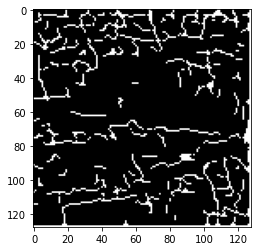

In [6]:
# Read image
img = cv2.imread("../imori.jpg").astype(np.float32)

canny = Canny_step3(img)
out = closing(canny, 1) 

# Save result
#plt.figure(figsize=(10, 20))
plt.imshow(out, cmap='gray')

cv2.imwrite('out50.jpg', out)